# MegaFon Uplift Competition

https://ods.ai/competitions/megafon-df21-comp

In [8]:
import sys

!{sys.executable} -m pip install scikit-uplift dill lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklift.datasets import fetch_megafon
from sklift.models import TwoModels
from sklift.metrics import qini_auc_score
from sklift.viz import plot_qini_curve


%matplotlib inline
seed=31

## Load Data

In [11]:
dataset = fetch_megafon()

print(f"Dataset type: {type(dataset)}\n")
print(f"Dataset features shape: {dataset.data.shape}")
print(f"Dataset target shape: {dataset.target.shape}")
print(f"Dataset treatment shape: {dataset.treatment.shape}")

  0%|          | 0.00/276M [00:00<?, ?iB/s]

Dataset type: <class 'sklearn.utils.Bunch'>

Dataset features shape: (600000, 50)
Dataset target shape: (600000,)
Dataset treatment shape: (600000,)


## EDA

In [12]:
dataset.data.head().append(dataset.data.tail())

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50
0,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,-12.534344,-58.279429,283.544750,-3.297557,74.491728,11.674656,-4.852843,99.324038,159.686346,-5.830570,-4.554391,-75.704888,-4.540720,107.891557,-0.592276,0.513937,-3.415607,-7.454581,-38.519996,-116.186909,18.253466,0.775597,-66.833169,121.204278,-58.588803,0.266334,0.758562,-13.254177,200.715580,77.227063,-230.591020,-3.023398,90.877638,134.363458,-213.584582,-2.092461,-93.973258,-0.155597,-312.130733,44.798182,-125.682413,16.231365
1,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,20.651652,181.635081,114.382486,10.277246,132.852421,-14.088731,82.011396,-19.290410,-155.851825,3.904401,26.194543,87.908221,115.714068,-179.564296,-1.202563,1.827663,87.042091,6.771393,12.481973,304.514135,3.618649,-0.422986,76.520982,67.402922,-407.896510,-1.269765,-34.027547,-91.572702,61.215866,-80.652713,-782.791784,-33.541388,-183.840746,72.864779,559.783584,1.142391,80.037124,-1.216185,-111.473936,-127.737977,-117.501171,10.732234
2,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,24.968496,-136.340629,628.310139,-7.714403,-4.863992,-41.638770,187.244122,16.716381,103.805977,15.248096,-7.963610,-18.581579,247.603883,-60.794763,-0.707689,-0.293637,186.251855,4.644561,-13.456976,52.765776,-95.096983,-2.191094,41.936533,17.929746,-243.263646,7.630227,-27.235726,38.757461,168.534929,94.979240,-177.641632,-40.559792,-203.637766,2.480242,96.998504,1.100962,-33.275159,0.920926,-679.492242,-91.009397,-18.173358,14.367636
3,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,-49.383641,-91.866107,374.208539,-5.197953,-16.972788,-20.513819,26.733826,-5.051170,266.620852,-1.003867,5.644895,101.563496,24.222458,15.445679,-0.193439,-0.537621,18.220545,-19.826745,-9.969067,-176.056848,-34.994979,-0.169379,20.194249,97.909989,41.396933,-4.572652,73.594603,59.882086,-18.703877,109.139592,-4.272029,18.375161,172.906875,83.951551,-323.642557,-0.369182,93.221948,-1.962380,-442.466684,-22.298302,-75.916603,11.634299
4,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,105.864805,258.607252,-555.119130,14.632472,100.997894,-10.130204,52.278128,-6.223072,-91.566718,24.962987,16.902873,-125.359051,77.880711,65.763350,-0.250273,0.470302,58.583197,24.301061,7.895425,64.681136,0.208348,1.215403,-32.063615,1.182104,-15.530264,9.247841,-40.267539,27.330542,-78.737771,-79.762654,-101.123230,-30.324588,125.577535,-208.531112,118.902324,-0.808578,-117.497906,1.770635,627.395611,122.019189,194.091195,-11.883858
599995,33.031482,0.584463,-25.546737,-35.129322,6.603716,-90.384229,-44.399223,71.343628,26.439937,125.557722,-148.814095,7.104286,5.991163,-21.188066,74.256391,-21.708865,-166.235195,-1.111755,9.607760,-61.550651,92.617018,20.961950,0.750728,-0.467848,69.668097,32.297833,-24.096069,289.287714,-31.464856,0.312659,-54.147572,-77.172624,-258.833150,-3.998705,26.506666,-24.779504,-122.438706,-62.827317,-303.385458,-3.976039,-183.820274,-167.259176,531.793092,-2.307605,-48.648490,0.763070,152.501250,-49.190995,149.292732,-15.031430
599996,-24.469552,1.175070,35.936859,19.577711,81.505532,-164.141125,-8.221423,38.864814,-2.410108,71.748724,58.957665,4.059674,-46.118695,4.432599,105.104558,22.963620,211.994758,-16.671940,-5.854626,-30.567135,116.775829,238.885395,-0.316791,0.910042,87.840767,13.377004,-2.927562,-125.278979,1.818772,-1.271766,-15.925201,49.134668,-114.101803,10.430417,11.934206,60.134324,18.355490,30.494051,23.169443,25.459914,103.792521,-87.706751,-230.298393,0.267790,-56.102467,-1.007702,-69.854583,187.924882,109.642972,25.022399
599997,-57.592800,1.033326,-20.608920,87.116236,-27.894756,120.864975,

In [13]:
dataset.data.describe()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50
count,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000
mean,-3.758503,0.000405,0.356208,-1.004378,3.376919,-6.396371,-2.253712,-6.432606,-0.061507,-1.659301,19.093492,-0.093886,-0.002533,-2.463280,13.161988,7.063375,6.858253,-0.020896,-0.985809,-1.114770,14.835209,-9.909231,0.002470,-0.002707,11.159296,0.024798,-0.978981,4.599121,-6.263516,0.000554,2.704003,0.027546,-6.514740,-0.005655,3.002134,5.325791,7.739900,-4.721989,-9.206852,2.728692,6.882868,-6.632834,8.454493,0.001296,0.007967,-0.000966,-22.259600,-5.759041,6.241130,-1.176456
std,54.881882,0.999419,31.804123,45.291429,53.397644,140.873734,59.810396,74.840857,44.912292,199.625148,455.894665,11.295157,56.797326,39.922589,114.277207,77.628539,190.951808,11.476030,26.239683,72.371005,138.517373,160.879307,0.999777,1.000431,104.195126,28.332643,13.729246,142.981246,75.071084,1.000134,51.108902,107.851987,153.130771,6.964937,47.529482,70.700510,134.675174,131.789351,197.493595,39.501936,163.776538,137.025868,262.840194,1.000368,71.553713,0.999902,500.900364,130.952113,141.211999,21.363662
min,-271.659497,-4.372119,-148.870768,-244.446728,-302.574049,-683.126343,-322.731683,-506.202937,-218.466369,-920.347783,-2289.294108,-52.074964,-313.255431,-195.457350,-636.553079,-533.404670,-913.011610,-55.140610,-125.733156,-330.755792,-770.324798,-774.266979,-4.545333,-4.708793,-579.451426,-126.515623,-64.651485,-732.116727,-399.414460,-4.553086,-346.728398,-515.521884,-743.800243,-32.088261,-251.277376,-348.076864,-668.793144,-700.110808,-1016.301591,-179.589370,-810.842593,-633.575178,-1345.838757,-4.756720,-360.713742,-4.516004,-2506.960013,-687.526201,-702.184241,-98.094323
25%,-40.693313,-0.673108,-20.758308,-30.644608,-31.865404,-100.762161,-42.313674,-54.840796,-30.327330,-134.565241,-286.292508,-7.613948,-38.401625,-29.205585,-62.727814,-36.893267,-121.868113,-7.752689,-18.645383,-50.050451,-77.058591,-117.394644,-0.671963,-0.676781,-57.964784,-19.118055,-10.247693,-91.190920,-56.366783,-0.674265,-30.975631,-72.732677,-109.888686,-4.711524,-26.971012,-42.250017,-82.922581,-93.661192,-142.413854,-23.338528,-102.658380,-99.033996,-167.634846,-0.673780,-48.250836,-0.675549,-357.547278,-93.163915,-88.803657,-15.580688
50%,-3.954771,0.000915,0.372583,-0.585368,3.720738,-6.357443,-2.263690,-6.416419,-0.103742,-1.628897,17.651122,-0.092166,-0.011893,-2.438805,13.426780,6.988854,6.639970,-0.030727,-1.007271,-1.084433,15.207025,-9.837197,0.001802,-0.003722,11.438983,0.023834,-0.946478,4.772537,-6.364402,-0.000372,2.732262,0.114877,-6.661874,-0.000436,2.966662,5.500324,7.516796,-4.835168,-9.003721,2.779691,7.190600,-6.784760,8.773280,0.001639,0.045537,-0.002251,-20.695017,-5.774627,6.286783,-1.199895
75%,33.174835,0.673056,21.495530,29.027860,38.988940,88.159514,37.709780,41.962767,30.144501,130.948487,324.226048,7.409305,38.291691,24.248160,89.130548,50.993029,135.756702,7.731675,16.690977,47.694238,106.788310,97.891879,0.677217,0.671145,80.327985,19.116412,8.309784,100.845315,43.792144,0.675415,36.369149,72.890914,96.255945,4.690724,32.898811,52.905711,98.388563,84.208344,124.149483,28.739188,116.755600,85.6

In [15]:
dataset.treatment.value_counts()

treatment    300368
control      299632
Name: treatment_group, dtype: int64

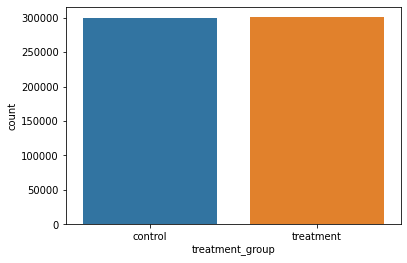

In [14]:
sns.countplot(x=dataset.treatment)

In [17]:
dataset.target.value_counts()

0    477486
1    122514
Name: conversion, dtype: int64

In [16]:
pd.crosstab(dataset.treatment, dataset.target, normalize='index')

conversion,0,1
treatment_group,,
control,0.820600,0.179400
treatment,0.771081,0.228919


## Baseline Model

In [18]:
dataset.treatment.loc[dataset.treatment == 'treatment'] = 1
dataset.treatment.loc[dataset.treatment == 'control'] = 0
dataset.treatment.value_counts()

1    300368
0    299632
Name: treatment_group, dtype: int64

In [19]:
stratify_cols = pd.concat([dataset.treatment, dataset.target], axis=1)

X_train, X_val, trmnt_train, trmnt_val, y_train, y_val = train_test_split(
    dataset.data,
    dataset.treatment,
    dataset.target,
    stratify=stratify_cols,
    test_size=0.3,
    random_state=31
)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

Train shape: (420000, 50)
Validation shape: (180000, 50)


In [20]:
treatment_model = lgb.LGBMClassifier(random_state=31)
control_model = lgb.LGBMClassifier(random_state=31)
tm = TwoModels(estimator_trmnt = treatment_model, estimator_ctrl = control_model, method='vanilla')

In [21]:
%%time
tm = tm.fit(X_train, y_train, trmnt_train)

CPU times: user 29 s, sys: 224 ms, total: 29.2 s
Wall time: 16.7 s


In [22]:
uplift_tm = tm.predict(X_val)

auqc = qini_auc_score(y_val, uplift_tm, trmnt_val) 
print(f"Qini coefficient on validation data: {auqc:.4f}")

Qini coefficient on validation data: 0.2395


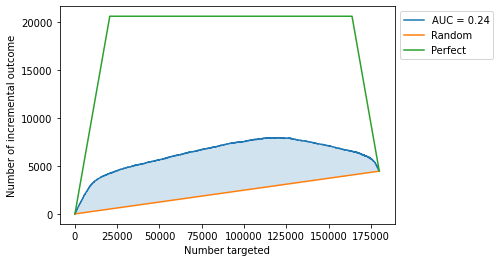

In [23]:
plot_qini_curve(y_val, uplift_tm, trmnt_val, perfect=True);

In [24]:
from sklift.metrics import (
    uplift_at_k,
    uplift_by_percentile,
    weighted_average_uplift,
    qini_auc_score,
    uplift_auc_score
)
from sklift.models import (
    ClassTransformation,
    SoloModel,
    TwoModels
)
from sklift.viz import (
    plot_uplift_by_percentile,
    plot_uplift_preds,
    plot_qini_curve,
    plot_uplift_curve
)

In [25]:
uplift_ct_avg = weighted_average_uplift(y_val, uplift_tm, trmnt_val, bins=10) 
print(f"average uplift: {uplift_ct_avg:.4f}")

pd.options.display.float_format = '{:,.3f}'.format
uplift_by_percentile(
    y_val, 
    uplift_tm, 
    trmnt_val, 
    strategy="overall", total=True, std=True, bins=10
)

average uplift: 0.0487


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,8985,9015,0.586,0.136,0.450,0.005,0.004,0.006
10-20,8996,9004,0.237,0.122,0.115,0.004,0.003,0.006
20-30,9037,8963,0.202,0.119,0.083,0.004,0.003,0.005
30-40,9015,8985,0.202,0.118,0.083,0.004,0.003,0.005
40-50,9078,8922,0.204,0.125,0.079,0.004,0.004,0.005
50-60,9005,8995,0.191,0.136,0.055,0.004,0.004,0.005
60-70,8993,9007,0.180,0.167,0.013,0.004,0.004,0.006
70-80,8929,9071,0.098,0.164,-0.067,0.003,0.004,0.005
80-90,8952,9048,0.087,0.166,-0.079,0.003,0.004,0.005


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


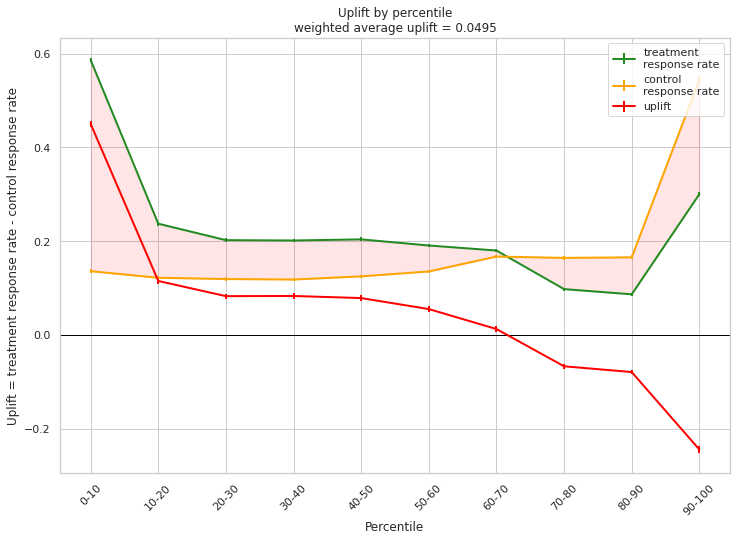

In [27]:
%matplotlib inline
plt.style.use('bmh')
sns.set_theme(style="whitegrid")

plot_uplift_by_percentile(y_val, uplift_tm, trmnt_val, strategy="overall", kind="line");
fig = plt.gcf()
fig.set_size_inches(12, 8)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


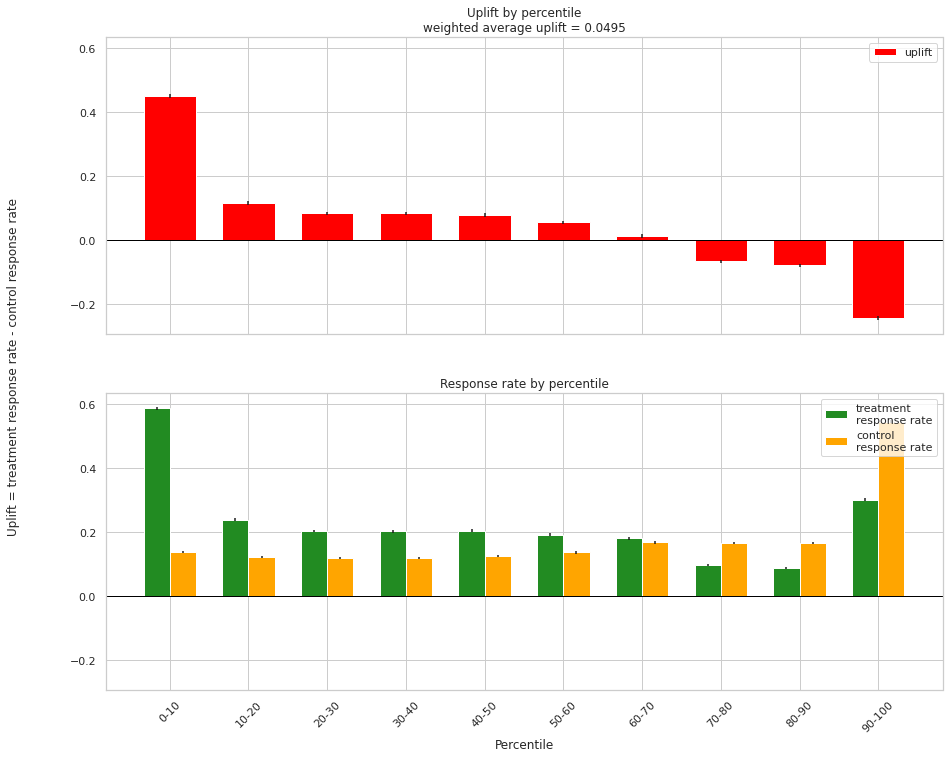

In [28]:
plot_uplift_by_percentile(y_val, uplift_tm, trmnt_val, strategy="overall", kind="bar");
fig = plt.gcf()
fig.set_size_inches(15, 12)

Qini coefficient: 0.240
Uplift auc score: 0.165


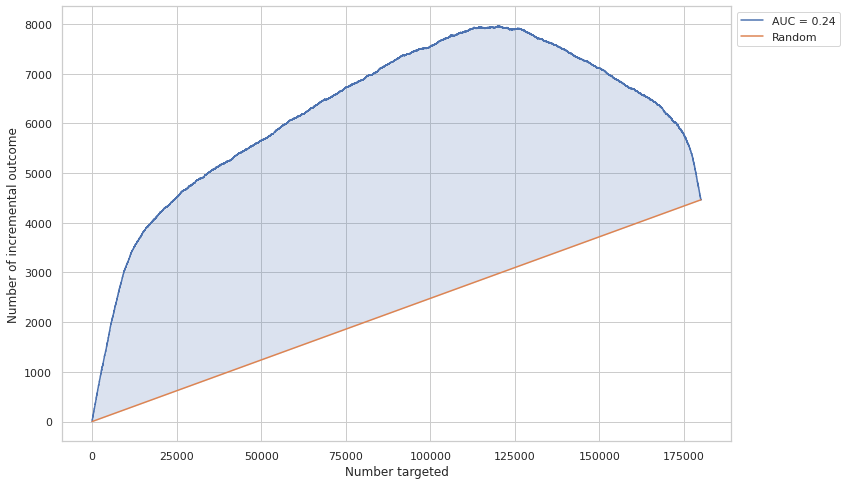

In [29]:
# AUQC = area under Qini curve = Qini coefficient
auqc = qini_auc_score(y_val, uplift_tm, trmnt_val) 
print(f"Qini coefficient: {auqc:.3f}")

auuc = uplift_auc_score(y_val, uplift_tm, trmnt_val) 
print(f"Uplift auc score: {auuc:.3f}")

# qini curve
plot_qini_curve(y_val, uplift_tm, trmnt_val, perfect=False);
fig = plt.gcf()
fig.set_size_inches(12, 8)